# **Task 3 - Reichardt Detectors**

<div>
    <img src="https://pbs.twimg.com/media/DV9-v1GW4AgTQoT.png" width=190px; height=230px, align='right'/>
</div>
<!-- https://ars.els-cdn.com/content/image/1-s2.0-S0960982217300738-gr1.jpg -->

This task will create an "Hassenstein-Reichardt detector", i.e. an elementary and hypothetical neural circuit inspired by the fruit fly. Such model is used to detect correlations between adjacent points in order to achieve motion perception. It consists of a cascade of spatial filter and temporal filter applied to adjacent locations on the input space. When an input (light, in case of visual systems) is received within a spatial kernel, a signal is sent and then delayed in time ($\tau$). If the moving object in the scene has the correct (preferred) speed and direction, it will activate the adjacent spatial kernel after a time that equals the previous delay $\tau$. The corresponding signal (with no delay) will then be summed to the delayed signal from the former location, eliciting an output in the final neuron. In case the object moves along the null direction (or with the wrong speed), the two signals will not be coincident and the final detector will thus not reach the firing threshold for emitting an output.

In this implementation, we will use event-based data relative to a moving bar recorded from a neuromorphic sensor. We will not use the whole pixel array of the sensor (346x260) but the central squared region with shape 60x60 and only the ON polarity. The bar may either move rightward (R) or leftward (L) with 3 different speeds (v1, v2, v3). Code for the initial data loading and pre-processing is given. The exercise focuses on building the architecture of the network, which will consist of:
- a first input neural population with 60x60 neurons (pixels);
- a convolutional neural layer of 6 LIF neurons applying spatial filtering with a 2D elongated gaussian kernel;
- two output populations (with 1 neuron each) of motion sensitive LIF neurons taking delayed inputs (thus applying temporal filtering) from neurons in the convolutional layer.

**Run the following cell before you start!**

In [ ]:
!git clone https://github.com/SimoNeT-Git/NC-ICT.git
import sys
sys.path.insert(0,'/content/NC-ICT')
from utils.DAVIS_numpy_utils import *
from utils.kernels import *

In [ ]:
!pip3 install dv
!pip3 install brian2
from dv import AedatFile
from brian2 import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

     |████████████████████████████████| 1.8MB 5.6MB/s 
     |████████████████████████████████| 491kB 24.3MB/s 
  Created wheel for dv: filename=dv-1.0.9-cp36-none-any.whl size=19786 sha256=9d911020902c383f5a88ace5932f00cb56c1a16ecabe103f0b8e9370d9d1c5a4
  Stored in directory: /root/.cache/pip/wheels/6d/51/5e/368db2f5a0b1bd1dbf6f0073a3589f24a478cbba82c147ea78
  Created wheel for zstd: filename=zstd-1.4.5.1-cp36-cp36m-linux_x86_64.whl size=1160129 sha256=58aeee35ef6afe2730b7f7693cfb39016e411ecf6831d44e16f15cd514d1dd67
  Stored in directory: /root/.cache/pip/wheels/40/92/41/c12f7f073170304327063b526be08ebd29b545d9f4c9841804
Successfully built dv zstd
     |████████████████████████████████| 1.2MB 5.4MB/s 
     |████████████████████████████████| 5.8MB 18.9MB/s 
  Created wheel for brian2: filename=Brian2-2.4.2-cp36-cp36m-linux_x86_64.whl size=1257530 sha256=c03eb997e818e1dc23830e67f62b6ebd6c093f56506ed02442e8e44e8342b2b7
  Stored in directory: /root/.cache/pip/wheels/5d/4b/cf/ef50e71df5479d

Define some parameters of the event-based data you want to load. Particularly, you may choose between 2 directions and 3 speeds of motion.

In [ ]:
# You may change these variables, related to the motion of the input stimulus:
direction = 'R'    # 'R' or 'L'
speed = 'v3'       # 'v1', 'v2' or 'v3'

# Do not change these variables:
duration = 0.3 * 10 ** 6   # duration of the simulation (us)
N_x, N_y = 346, 260        # shape of the whole DAVIS pixel array
input_size = 60            # shape of the central squared region we will consider

## Load & Process Data

Load the event-based data file (with AEDAT4 extension) containing all outputs from the DAVIS sensor. Store DVS events in a numpy array.

In [ ]:
file = "/content/NC-ICT/data/bar_" + direction + '_' + speed + ".aedat4"
with AedatFile(file) as f:
    # Put all events in a structured numpy array
    events_struct = np.hstack([event_packet for event_packet in f['events'].numpy()])
    # Access information of events by type
    ts, x, y, pol = events_struct['timestamp'], events_struct['x'], events_struct['y'], events_struct['polarity']
    # Put info in a 4d-array with N rows (number of events) and 4 columns (ts, x, y, p)
    events = np.stack((ts, x, y, pol)).T

Show the DVS recording and distinguish between ON and OFF events with colors (green and red respectively).

In [ ]:
dvsvid_on, dvsvid_off = dvs_computevideofreq_onoff(dvs_flattenaddress(events, N_x, N_y), N_x, N_y, rate=50)
minval, maxval = min(dvsvid_on.min(), dvsvid_off.min()), max(dvsvid_on.max(), dvsvid_off.max())
frames_dvs = np.zeros((*dvsvid_on.shape, 3))  # RGB video
frames_dvs[:, :, :, 0] = np.uint8(np.interp(dvsvid_off, (minval, maxval), (0, 255)))
frames_dvs[:, :, :, 1] = np.uint8(np.interp(dvsvid_on, (minval, maxval), (0, 255)))

fig = plt.figure(figsize=(5, 4))
plt.title('DVS video: ON=green, OFF=red')
plt.axis('off')
plot_dvs_frames = []
for frame in frames_dvs:
    dvs_image = plt.imshow(frame.astype(np.uint8), vmin=0, vmax=255, animated=True)
    plot_dvs_frames.append([dvs_image])
plt.close()
animation.ArtistAnimation(fig, plot_dvs_frames, interval=30, blit=True, repeat_delay=1000)

Pre-process the event-based data (mainly, cut the pixel array, cut the recording in the period where the stimulus is present and select ON events only). Then store timestamps and pixel addresses of events in different variables. We will use those as input to the network through a "*SpikeGeneratorGroup*".

In [ ]:
dvs = dvs_cut_pixelarray(events, input_size, N_x, N_y)  # cut the pixel array to a squared region
dvs_flat = dvs_flattenaddress(dvs, input_size, input_size)  # from (x,y) coordinate to flatten index
dvs_flat_on = dvs_select_polarity(dvs_flat, polarity='on')  # select only ON events and remove the others
start = dvs_compute_start(dvs_flat_on, input_size, input_size, duration)  # compute the moment when the stimulus starts to move in the central region
dvs_flat_on = dvs_cut_timewindow(dvs_flat_on, start, start + duration)  # remove all events occurring before 'start' and after 'start + duration'
dvs_flat_on = dvs_timereset(dvs_flat_on)  # reset timestamps so that first event has 0 timestamp
ts, id = dvs_return_id_and_ts(dvs_flat_on)  # separate timestamps and flattened-address of events' array
ts, id = dvs_refractory_filter(address=id, timestamp=ts, refractory=100)  # apply refractory filter for a 100 us refractory period

Show the remaining events.

In [ ]:
dvsvid_on = dvs_computevideofreq(dvs_flat_on, input_size, input_size, rate=80)
minval, maxval = dvsvid_on.min(), dvsvid_on.max()
frames_dvs = np.zeros((*dvsvid_on.shape, 3))  # RGB video
frames_dvs[:, :, :, 1] = np.uint8(np.interp(dvsvid_on, (minval, maxval), (0, 255)))

fig = plt.figure(figsize=(5, 4))
plt.title('DVS video: ON=green, OFF=red')
plt.axis('off')
plot_dvs_frames = []
for frame in frames_dvs:
    dvs_image = plt.imshow(frame.astype(np.uint8), vmin=0, vmax=255, animated=True)
    plot_dvs_frames.append([dvs_image])
plt.close()
animation.ArtistAnimation(fig, plot_dvs_frames, interval=80, blit=True, repeat_delay=1000)

## Define Convolution

Given the kernel dimension, convolution information and the shape of the input space, compute the dimension that the convolutional layer (the neural population after spatial filtering) must have.

In [ ]:
kernel_sigma = 4
kernel_elongation = 10
kernel_th = 0.5
stride = 10
kernel_size = compute_dim_gauss2d_elong(input_size, sigma=kernel_sigma, p=kernel_elongation, threshold=kernel_th)
output_size, error_conv = convolution_out_shape(input_size, kernel_size=kernel_size, stride=stride, return_error=True)
print('Information of convolution on input pixel array:\n'
      ' - input shape of pixel array is {}\n'
      ' - kernel dimension is {}\n'
      ' - stride is {}\n'
      ' - output shape of convolutional layer is {}\n'
      ' - error in sliding kernel over input is {}'
      .format(input_size, kernel_size, stride, output_size, round(error_conv, 2)))

Information of convolution on input pixel array:
 - input shape of pixel array is 60
 - kernel dimension is 9
 - stride is 10
 - output shape of convolutional layer is 6
 - error in sliding kernel over input is 0.1


Visualise convolution: show the spatial kernel sliding on the input space.

In [ ]:
all_kernels = np.zeros((output_size, input_size ** 2))
y_center = int(round(input_size / 2))
for x in range(output_size):
  x_center = x * stride + int(round((kernel_size - 1) / 2))
  target = np.ravel_multi_index((y_center, x_center), (input_size, input_size))
  # i.e. target =  x_center + y_center * input_size
  all_kernels[x, :] = gauss2d_elong(target, sigma=kernel_sigma, p=kernel_elongation, teta=90, space_dim=input_size, threshold=kernel_th)
all_kernels = all_kernels.reshape(output_size, input_size, input_size)

fig = plt.figure(figsize=(5, 4))
plt.title('Sliding Spatial Kernel')
plt.axis('off')
plot_kernel = []
for kernel in all_kernels:
    kernel_image = plt.imshow(kernel * 255, vmin=0, vmax=255, animated=True)
    plot_kernel.append([kernel_image])
plt.close()
animation.ArtistAnimation(fig, plot_kernel, interval=500, blit=True)

## Build Network Architecture & Run Simulation

Setup the simulation to use 0.1ms timesteps.

In [ ]:
# Write your code here

In [ ]:
#@title Double-click here for solution
defaultclock.dt = 100 * us

Create the input neural population (hint: use a "*SpikeGeneratorGroup*"). Neurons *id* must spike at times *ts*.

In [ ]:
# Input layer (events from the sensor)
Layer_input = # ...

In [ ]:
#@title Double-click here for solution

# Input layer (events from the sensor)
Layer_input = SpikeGeneratorGroup(input_size ** 2, indices=id, times=ts * us,
                                  name='layer_input')

Define the LIF neuron model. The resting value is -65mV, the threshold -50mV, the membrane time constant 2ms and the synapse time constant 5ms. Then create convolutional layer with a number of neurons equal to *ouput_size*. The reset potential is equal to the resting value and the refractory period is 150ms. Remember to initialize the membrane potential to the resting value.

In [ ]:
# Define neuron model and parameters
model = # ...

# Convolutional layer
Layer_convolution = # ...

In [ ]:
#@title Double-click here for solution

# Neuron model
tau_m = 2 * ms
tau_s = 5 * ms
u_th = - 50 * mV
u_rest = - 65 * mV
model = '''
du/dt = - (u - u_rest - u_s) / tau_m  : volt  (unless refractory)
du_s/dt = - u_s / tau_s               : volt
'''
# Convolutional layer
Layer_convolution = NeuronGroup(output_size, model, threshold="u >= u_th",
                                reset="u = u_rest", method="euler", refractory=150 * ms, name='layer_conv')
Layer_convolution.u = u_rest

Create the two output population with 1 LIF neuron each. The reset potential is equal to the resting value and the refractory period is 50ms.

In [ ]:
# RIGHTWARD Reichardt detector neuron
Layer_reichardt_R = # ...

# LEFTWARD Reichardt detector neuron
Layer_reichardt_L = # ...

In [ ]:
#@title Double-click here for solution

# RIGHTWARD Reichardt detector neuron
Layer_reichardt_R = NeuronGroup(1, model, threshold="u >= u_th",
                                reset="u = u_rest", method="euler", refractory=50 * ms, name='layer_reichardt_R')
Layer_reichardt_R.u = u_rest
# LEFTWARD Reichardt detector neuron
Layer_reichardt_L = NeuronGroup(1, model, threshold="u >= u_th",
                                reset="u = u_rest", method="euler", refractory=50 * ms, name='layer_reichardt_L')
Layer_reichardt_L.u = u_rest

Create the convolution synapses group, defining the spatial filtering between the input population and the convolutional layer. The kernel (shown in the animation above) should shift only along the x dimension of the input space by a number of pixels defined by the variable *stride*. The variables *x_center* and *y_center* define the coordinates of the central pixel of the kernel.

In [ ]:
# Synapses: convolution
Syn_convolution = # ...

y_center = # ...

kernel_weights = np.asarray([])
for x in range(output_size):

    x_center = # ...

    target_pixel = x_center + y_center * input_size
    kernel = gauss2d_elong(target_pixel, sigma=kernel_sigma, p=kernel_elongation, teta=90, space_dim=input_size, threshold=kernel_th)
    indices_kernel = np.where(kernel >= kernel_th)[0]
    Syn_convolution.connect(i=indices_kernel, j=x)
    kernel_weights = np.concatenate((kernel_weights, kernel[indices_kernel]))
Syn_convolution.w = kernel_weights * mV

In [ ]:
#@title Double-click here for solution

# Synapses: convolution
Syn_convolution = Synapses(Layer_input, Layer_convolution,
                           model='w : volt', on_pre='u_s += w', name='Syn_conv')
kernel_weights = np.asarray([])
y_center = int(round(input_size / 2))
for x in range(output_size):
    target_neuron = x
    x_center = x * stride + int(round((kernel_size - 1) / 2))
    target_pixel = np.ravel_multi_index((y_center, x_center), (input_size, input_size))
    # i.e. target_pixel = x_center + y_center * input_size
    kernel = gauss2d_elong(target_pixel, sigma=kernel_sigma, p=kernel_elongation, teta=90, space_dim=input_size, threshold=kernel_th)
    indices_kernel = np.where(kernel >= kernel_th)[0]
    Syn_convolution.connect(i=indices_kernel, j=target_neuron)
    kernel_weights = np.concatenate((kernel_weights, kernel[indices_kernel]))
Syn_convolution.w = kernel_weights * mV

Create 2 delayed synapses groups (defining the temporal filtering) between the convolution layer and the 2 output (motion sensitive) neurons. Connectivity should be "all-to-all" and all weights should be equal to 10mV. The delay between adjacent spatial filters should be equal to *delay_reichardt*. In case of rightward sensitivity, the delay should decrease from the first synapse (connecting the first neuron of the convolutional population with the R neuron) to the last (connecting the last neuron of the convolutional population with the R neuron): i.e. the last synapse should have 0 delay, the second *delay_reichardt* and so on. In case of leftward sensitivity, the delay should increase from the first synapse to the last one. Note that, as we fixed the spatial filtering, the delay is what defines the preferred speed of the neurons and must therefore be adapted to the speed of the bar.

In [ ]:
# Adapt the delay to the speed of the input stimulus 
delay_reichardt = {'v1': 6, 'v2': 30, 'v3': 50}.get(speed) * ms

# Synapses: reichardt model - RIGHTWARD motion selectivity
Syn_reichardt_R = # ...

# Synapses: reichardt model - LEFTWARD motion selectivity
Syn_reichardt_L = # ...

In [ ]:
#@title Double-click here for solution

# Adapt the delay to the speed of the input stimulus
delay_reichardt = {'v1': 6, 'v2': 30, 'v3': 50}.get(speed) * ms

# Synapses: reichardt model - RIGHTWARD motion selectivity
Syn_reichardt_R = Synapses(Layer_convolution, Layer_reichardt_R,
                           model='w : volt', on_pre='u_s += w', name='Syn_reichardt_R')
Syn_reichardt_R.connect()
Syn_reichardt_R.w = 10 * mV
for k in range(Layer_convolution.N):
    Syn_reichardt_R.delay[k] = delay_reichardt * (Layer_convolution.N - k - 1)
# Synapses: reichardt model - LEFTWARD motion selectivity
Syn_reichardt_L = Synapses(Layer_convolution, Layer_reichardt_L,
                           model='w : volt', on_pre='u_s += w', name='Syn_reichardt_L')
Syn_reichardt_L.connect()
Syn_reichardt_L.w = 10 * mV
for k in range(Layer_convolution.N):
    Syn_reichardt_L.delay[k] = delay_reichardt * k

Monitor membrane potentials and spikes from the convolutional layer and both output neurons.

In [ ]:
# Write your code here 

In [ ]:
#@title Double-click here for solution

# Monitors
Mon_state_conv = StateMonitor(Layer_convolution, 'u', record=True)
Mon_spike_conv = SpikeMonitor(Layer_convolution)
Mon_state_out_R = StateMonitor(Layer_reichardt_R, 'u', record=True)
Mon_spike_out_R = SpikeMonitor(Layer_reichardt_R)
Mon_state_out_L = StateMonitor(Layer_reichardt_L, 'u', record=True)
Mon_spike_out_L = SpikeMonitor(Layer_reichardt_L)

Build and feed the network object.

In [ ]:
# Write your code here

In [ ]:
#@title Double-click here for solution

# Create network
net = Network(Layer_input, Layer_convolution, Syn_convolution,
              Layer_reichardt_R, Syn_reichardt_R, Layer_reichardt_L, Syn_reichardt_L,
              Mon_state_conv, Mon_spike_conv,
              Mon_state_out_R, Mon_spike_out_R,
              Mon_state_out_L, Mon_spike_out_L)

Run the simulation for 300ms.

In [ ]:
# Write your code here 

In [ ]:
#@title Double-click here for solution

# Run the simulation
net.run(duration * us, report='stdout')

Starting simulation at t=0. s for a duration of 300. ms
300. ms (100%) simulated in < 1s


Plot the membrane potentials of all neurons in the convolutional layer and show a rasterplot of all spikes in such layer.

In [ ]:
# Write your code here

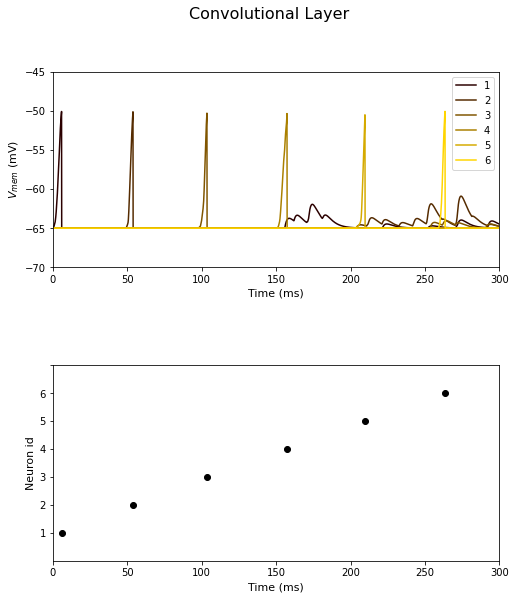

In [ ]:
#@title Double-click here for solution

figure(figsize=(8,9))
suptitle('Convolutional Layer', fontsize=16)
subplot(2, 1, 1)
for k in range(Layer_convolution.N):
  color = ((k+1)/(Layer_convolution.N), k/(Layer_convolution.N), 0)
  plot(Mon_state_conv.t / ms, Mon_state_conv.u[k] / mV, c=color, label='%s' % (k + 1))
legend()
xlabel('Time (ms)', fontsize=11)
ylabel('$V_{mem}$ (mV)', fontsize=11)
xlim(0, duration * 10 ** -3)
ylim(u_rest / mV - 5, u_th / mV + 5)
subplot(2, 1, 2)
plot(Mon_spike_conv.t / ms, Mon_spike_conv.i, 'ok')
xlabel('Time (ms)', fontsize=11)
ylabel('Neuron id', fontsize=11)
xlim(0, duration * 10 ** -3)
ylim(-1, Layer_convolution.N)
yticks(range(0, Layer_convolution.N + 1), range(1, Layer_convolution.N + 1))
subplots_adjust(hspace=0.5)
show()

**From the rasterplot, you should notice that the moving bar defines an orientation in space-time, where the sign of the slope is related to the direction of the motion and its magnitude is related to the speed.**

Print the time interval between spikes in consecutive neurons of the convolutional layer. If the preferred speed of the output neurons matches the actual speed of the input stimulus, such delays should all be very close to the one that we have set between adjacent spatial filters.

In [ ]:
# Write your code here 

In [ ]:
#@title Double-click here for solution

print('The delay between adjacent spatial kernels is', delay_reichardt / ms, 'ms.')
if len(Mon_spike_conv.t) >= 2:
    spikes_isi = np.diff(Mon_spike_conv.t / ms)
    print('Mean ISI between nearby neurons of convolutional layer is', round(np.mean(spikes_isi), 2),
          'ms, with a standard deviation of', round(np.std(spikes_isi), 2),
          'ms. All ISI values are:', spikes_isi, 'ms.')
else:
    print('None or less than 2 neurons in the convolutional layer spiked, '
          'the input firing rate of DVS events (or the weight of the spatial kernel) is too low.')

The delay between adjacent spatial kernels is 50.0 ms.
Mean ISI between nearby neurons of convolutional layer is 51.54 ms, with a standard deviation of 2.32 ms. All ISI values are: [48.  49.7 53.8 52.4 53.8] ms.


Plot the membrane potentials of the 2 output neurons and show a rasterplot of their spiking activity.

In [ ]:
# Write your code here

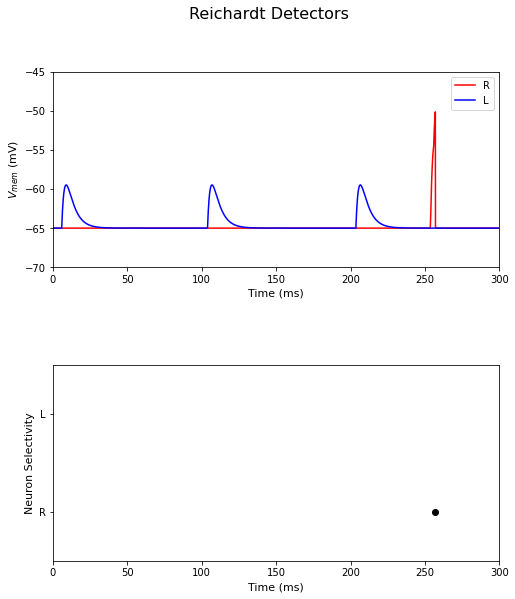

In [ ]:
#@title Double-click here for solution

figure(figsize=(8,9))
suptitle('Reichardt Detectors', fontsize=16)
subplot(2, 1, 1)
plot(Mon_state_out_R.t / ms, Mon_state_out_R.u[0] / mV, c='r', label='R')
plot(Mon_state_out_L.t / ms, Mon_state_out_L.u[0] / mV, c='b', label='L')
legend()
xlabel('Time (ms)', fontsize=11)
ylabel('$V_{mem}$ (mV)', fontsize=11)
xlim(0, duration * 10 ** -3)
ylim(u_rest / mV - 5, u_th / mV + 5)
subplot(2, 1, 2)
plot(Mon_spike_out_R.t / ms, Mon_spike_out_R.i, 'ok')
plot(Mon_spike_out_L.t / ms, Mon_spike_out_L.i + 1, 'ok')
xlabel('Time (ms)', fontsize=11)
ylabel('Neuron Selectivity', fontsize=11)
xlim(0, duration * 10 ** -3)
ylim(-0.5, 1.5)
yticks([0, 1], ['R', 'L'])
subplots_adjust(hspace=0.5)
show()

**Only the neuron that is sensitive to the same direction of motion as the input bar should fire a spike. In this case, the input spikes from the convolutional layer will be coincident (thanks to the correct temporal filterings) thus summing up and triggering the target neuron. Instead, the inputs of the neuron sensitive to the opposite direction will not be coincident and this detector will thus not reach the firing threshold for emitting a spike.**


---

#### **Extensions**

1. Try to change the direction and speed of the input data and watch the resulting behavior of the network.
2. Try to add some other output neurons sensitive to different speeds of motion to view their response in case of non-preferred input speeds. Particularly, if you set the delay for the first pair of output neurons (R and L) so that their sensitivity is to the speed *v1*, you may add 2 more pairs of neurons sensitive to the speeds *v2* and *v3* respectively. Then change speed and direction of the stimulus and observe the activity of all such neurons. Note: this task is left to the most willing students and the solution will <u>not</u> be given.

In [ ]:
#@title Double-click here to view the solution for extension 1

# ============================ Load & Process Data =============================
# You may change these variables, related to the motion of the input stimulus:
direction = 'L'    # 'R' or 'L'
speed = 'v2'       # 'v1', 'v2' or 'v3'
# Do not change these variables:
duration = 0.3 * 10 ** 6   # duration of the simulation (us)
N_x, N_y = 346, 260        # shape of the whole DAVIS pixel array
input_size = 60            # shape of the central squared region we will consider
# Load the aedat4 file
file = "drive/My Drive/Neuromorphic_Exe20-21/data/bar_" + direction + '_' + speed + ".aedat4"
with AedatFile(file) as f:
    # Put all events in a structured numpy array
    events_struct = np.hstack([event_packet for event_packet in f['events'].numpy()])
    # Access information of events by type
    ts, x, y, pol = events_struct['timestamp'], events_struct['x'], events_struct['y'], events_struct['polarity']
    # Put info in a 4d-array with N rows (number of events) and 4 columns (ts, x, y, p)
    events = np.stack((ts, x, y, pol)).T
# Pre-process DVS data
dvs = dvs_cut_pixelarray(events, input_size, N_x, N_y)  # cut the pixel array to a squared region
dvs_flat = dvs_flattenaddress(dvs, input_size, input_size)  # from (x,y) coordinate to flatten index
dvs_flat_on = dvs_select_polarity(dvs_flat, polarity='on')  # select only ON events and remove the others
start = dvs_compute_start(dvs_flat_on, input_size, input_size, duration)  # compute the moment when the stimulus starts to move in the central region
dvs_flat_on = dvs_cut_timewindow(dvs_flat_on, start, start + duration)  # remove all events occurring before 'start' and after 'start + duration'
dvs_flat_on = dvs_timereset(dvs_flat_on)  # reset timestamps so that first event has 0 timestamp
ts, id = dvs_return_id_and_ts(dvs_flat_on)  # separate timestamps and flattened-address of events' array
ts, id = dvs_refractory_filter(address=id, timestamp=ts, refractory=100)  # apply refractory filter for a 100 us refractory period

# ============================= Define Convolution =============================
kernel_sigma = 4
kernel_elongation = 10
kernel_th = 0.5
stride = 10
kernel_size = compute_dim_gauss2d_elong(input_size, sigma=kernel_sigma, p=kernel_elongation, threshold=kernel_th)
output_size, error_conv = convolution_out_shape(input_size, kernel_size=kernel_size, stride=stride, return_error=True)

# ============================ Network Architecture ============================
# Define all the paramters for the simulation, giving them appropriate dimensions (!)

# ................ 1. Setup the time-step of the simulation
defaultclock.dt = 100 * us

# ................ 2. Create the neural populations
# Neuron model
tau_m = 2 * ms
tau_s = 5 * ms
u_th = - 50 * mV
u_rest = - 65 * mV
model = '''
du/dt = - (u - u_rest - u_s) / tau_m  : volt  (unless refractory)
du_s/dt = - u_s / tau_s               : volt
'''
# Input layer (events from the sensor)
Layer_input = SpikeGeneratorGroup(input_size ** 2, indices=id, times=ts * us,
                                  name='layer_input')
# Convolutional layer
Layer_convolution = NeuronGroup(output_size, model, threshold="u >= u_th",
                                reset="u = u_rest", method="euler", refractory=150 * ms, name='layer_conv')
Layer_convolution.u = u_rest
# Reichardt detector layer - RIGHTWARD motion selectivity
Layer_reichardt_R = NeuronGroup(1, model, threshold="u >= u_th",
                                reset="u = u_rest", method="euler", refractory=50 * ms, name='layer_reichardt_R')
Layer_reichardt_R.u = u_rest
# Reichardt detector layer - LEFTWARD motion selectivity
Layer_reichardt_L = NeuronGroup(1, model, threshold="u >= u_th",
                                reset="u = u_rest", method="euler", refractory=50 * ms, name='layer_reichardt_L')
Layer_reichardt_L.u = u_rest

# ................ 3. Create the synapses
# Synapses: convolution
Syn_convolution = Synapses(Layer_input, Layer_convolution,
                           model='w : volt', on_pre='u_s += w', name='Syn_conv')
kernel_weights = np.asarray([])
y_center = int(round(input_size / 2))
for x in range(output_size):
    target_neuron = x
    x_center = x * stride + int(round((kernel_size - 1) / 2))
    target_pixel = np.ravel_multi_index((y_center, x_center), (input_size, input_size))
    # i.e. target_pixel = x_center + y_center * size_in
    kernel = gauss2d_elong(target_pixel, sigma=kernel_sigma, p=kernel_elongation, teta=90, space_dim=input_size, threshold=kernel_th)
    indices_kernel = np.where(kernel >= kernel_th)[0]
    Syn_convolution.connect(i=indices_kernel, j=target_neuron)
    kernel_weights = np.concatenate((kernel_weights, kernel[indices_kernel]))
Syn_convolution.w = kernel_weights * mV
# Adapt the temporal filtering to the speed of the input bar
delay_reichardt = {'v1': 6, 'v2': 30, 'v3': 50}.get(speed) * ms
# Synapses: reichardt model - RIGHTWARD motion selectivity
Syn_reichardt_R = Synapses(Layer_convolution, Layer_reichardt_R,
                           model='w : volt', on_pre='u_s += w', name='Syn_reichardt_R')
Syn_reichardt_R.connect()
Syn_reichardt_R.w = 10 * mV
for k in range(Layer_convolution.N):
    Syn_reichardt_R.delay[k] = delay_reichardt * (Layer_convolution.N - k - 1)
# Synapses: reichardt model - LEFTWARD motion selectivity
Syn_reichardt_L = Synapses(Layer_convolution, Layer_reichardt_L,
                           model='w : volt', on_pre='u_s += w', name='Syn_reichardt_L')
Syn_reichardt_L.connect()
Syn_reichardt_L.w = 10 * mV
for k in range(Layer_convolution.N):
    Syn_reichardt_L.delay[k] = delay_reichardt * k
# ................ 4. Setup data monitoring
Mon_state_conv = StateMonitor(Layer_convolution, 'u', record=True)
Mon_spike_conv = SpikeMonitor(Layer_convolution)
Mon_state_out_R = StateMonitor(Layer_reichardt_R, 'u', record=True)
Mon_spike_out_R = SpikeMonitor(Layer_reichardt_R)
Mon_state_out_L = StateMonitor(Layer_reichardt_L, 'u', record=True)
Mon_spike_out_L = SpikeMonitor(Layer_reichardt_L)
# ................ 5. Build and feed the network object
net = Network(Layer_input, Layer_convolution, Syn_convolution,
              Layer_reichardt_R, Syn_reichardt_R, Layer_reichardt_L, Syn_reichardt_L,
              Mon_state_conv, Mon_spike_conv,
              Mon_state_out_R, Mon_spike_out_R,
              Mon_state_out_L, Mon_spike_out_L)
# ................ 6. Run the simulation
net.run(duration * us, report='stdout')

# ................ 7. Plot the recorded data
figure(figsize=(8,9))
suptitle('Convolutional Layer', fontsize=16)
subplot(2, 1, 1)
for k in range(Layer_convolution.N):
  color = ((k+1)/(Layer_convolution.N), k/(Layer_convolution.N), 0)
  plot(Mon_state_conv.t / ms, Mon_state_conv.u[k] / mV, c=color, label='%s' % (k + 1))
legend()
xlabel('Time (ms)', fontsize=11)
ylabel('$V_{mem}$ (mV)', fontsize=11)
xlim(0, duration * 10 ** -3)
ylim(u_rest / mV - 5, u_th / mV + 5)
subplot(2, 1, 2)
plot(Mon_spike_conv.t / ms, Mon_spike_conv.i, 'ok')
xlabel('Time (ms)', fontsize=11)
ylabel('Neuron id', fontsize=11)
xlim(0, duration * 10 ** -3)
ylim(-1, Layer_convolution.N)
yticks(range(0, Layer_convolution.N + 1), range(1, Layer_convolution.N + 1))
subplots_adjust(hspace=0.5)
show()

print('The delay between adjacent spatial kernels is', delay_reichardt / ms, 'ms.')
if len(Mon_spike_conv.t) >= 2:
    spikes_isi = np.diff(Mon_spike_conv.t / ms)
    print('Mean ISI between nearby neurons of convolutional layer is', round(np.mean(spikes_isi), 2),
          'ms, with a standard deviation of', round(np.std(spikes_isi), 2),
          'ms. All ISI values are:', spikes_isi, 'ms.')
else:
    print('None or less than 2 neurons in the convolutional layer spiked, '
          'the input firing rate of DVS events (or the weight of the spatial kernel) is too low.')

figure(figsize=(8,9))
suptitle('Reichardt Detectors', fontsize=16)
subplot(2, 1, 1)
plot(Mon_state_out_R.t / ms, Mon_state_out_R.u[0] / mV, c='r', label='R')
plot(Mon_state_out_L.t / ms, Mon_state_out_L.u[0] / mV, c='b', label='L')
legend()
xlabel('Time (ms)', fontsize=11)
ylabel('$V_{mem}$ (mV)', fontsize=11)
xlim(0, duration * 10 ** -3)
ylim(u_rest / mV - 5, u_th / mV + 5)
subplot(2, 1, 2)
plot(Mon_spike_out_R.t / ms, Mon_spike_out_R.i, 'ok')
plot(Mon_spike_out_L.t / ms, Mon_spike_out_L.i + 1, 'ok')
xlabel('Time (ms)', fontsize=11)
ylabel('Neuron Selectivity', fontsize=11)
xlim(0, duration * 10 ** -3)
ylim(-0.5, 1.5)
yticks([0, 1], ['R', 'L'])
subplots_adjust(hspace=0.5)
show()